# Analysing data from multiple subjects

#### Setting up Python
We need to make sure we have our virtual environment we created during the `MNE-tutorial`.

1. Press `Select Kernel`, then `Python Environments...` and then choose any Python kernel. 
2. Run the code chunk below
3. Change the kernel used to run the code in this notebook. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

In [1]:
!bash ../env_to_ipynb_kernel.sh

Installed kernelspec env in /home/ucloud/.local/share/jupyter/kernels/env


## Importing packages

In [2]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path

# importing Lauras homemade functions for preprocessing
import sys
sys.path.append("..")
from helper_functions import preproc_subject, update_event_ids, update_events_group1_group2, event_id

## Now lets get started!

In [8]:
# dictionary with subjects and their bad channels
subjects = {
    "1": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "2": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "3": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "4": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "5": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "6": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
}

evokeds_subjects = {}

# path to the data folder 
data_folder = Path("/work/EEG_lab/raw")

# loop over the subjects and preprocess their data
for subject, params in subjects.items():
    # load EEG data
    data_path = data_folder / "EEG" / f"group{subject}.vhdr"
    raw = mne.io.read_raw_brainvision(data_path)
    raw.load_data()

    # clean logfile
    logfile_path = data_folder / "behavioural" / f"subject-{subject}.csv"
    logfile = pd.read_csv(logfile_path)
    
    logfile["target_gender"] = logfile["target_gender"].apply(lambda x: x.strip())
    logfile["target_gender"] = logfile["target_gender"].apply(lambda x: x.strip("??"))

    events, _ = mne.events_from_annotations(raw)

    if subject in ["1", "2"]:
        logfile = logfile[logfile["practice"]=="no"]
        events = update_events_group1_group2(events, event_id, logfile)
    
    # preprocess the data
    epochs = preproc_subject(
        raw, 
        events = events,
        event_id = update_event_ids(events, event_id), 
        bad_channels = params["bad_channels"],
        reject = {"eeg":150e-6}, 
        l_freq = 1, 
        h_freq = 40, 
        tmin = -0.2, 
        tmax = 0.5, 
        baseline = (None, 0)
        )

    subjects[subject]["epochs"] = epochs


    # you can add what you are interested in here:
    evokeds_subjects[subject] = {
        "word":epochs["word"].average(),
        "response":epochs["response"].average(),
        "word_female":epochs["word/female"].average(),
        "word_male":epochs["word/male"].average(),
        "m":epochs["m"].average(),
        "z":epochs["z"].average(),
        }



Extracting parameters from /work/EEG_lab/raw/EEG/group1.vhdr...
Setting channel info structure...
Reading 0 ... 531959  =      0.000 ...   531.959 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 30')]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
504 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 504 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'P7', 'O1', 'Oz', 'P8', 'TP10', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'CP5', 'Pz', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT9

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
504 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 504 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'P7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['P8']
6 bad epochs dropped
Extracting parameters from /work/EEG_lab/raw/EEG/group3.vhdr...
Setting channel info structure...
Reading 0 ... 558579  =      0.000 ...   558.579 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32'), np.str_('Stimulus/S 40')

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
271 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 271 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : [

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
478 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 478 events and 701 original time points ...
0 bad epochs dropped
Extracting parameters from /work/EEG_lab/raw/EEG/group5.vhdr...
Setting channel info structure...
Reading 0 ... 680739  =      0.000 ...   680.739 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32'), np.str_('Stimulus/S 40'), np.str_('Stimulus/S111'), np.str_('Stimulus/S112'), np.str_('Stimulus/S113'), np.str_('Stimulus/S114'), np.str_('Stimulus/S121'), np.str_('Stimulus/S122'), np.str_('Stimulus/S123'), np.str_('Stimulus/S124'), np.str_('Stimulus/S131'), np.str_('Stimulus/S132'), np.str_(

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
504 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 504 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Oz', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P4', 'P8']
    Rejecting  epoch based on EEG : ['P3', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'Fp2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'TP9', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'TP10']
    Rejecting  epoch based on EEG : ['T8']
8 bad epochs dropped
Extracting parameters from /work/EEG_lab/raw/EEG/group6.vhdr...
Setting channel info structure...
Reading 0 ... 864039  =      0.000 ...   864.039 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 11

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Not setting metadata
504 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 504 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['TP9', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['TP9', 'O1']
    Rejecting  epoch based on EEG : ['TP9', 'O1']
    Rejecting  epoch based on EEG : ['TP9', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'O1', 'Oz', 'O2', 'TP10']
    Rejecting  epoch

In [9]:
GA_evo = {"word": None, "response": None, "word_female": None, "word_male": None, "m":None, "z":None}

for evo in GA_evo:
    GA_evo[evo] = mne.grand_average([params[evo] for sub, params in evokeds_subjects.items()])


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


# Analysis and plotting

Now play around with plotting of a few different contrasts. You can rely on the example below, investigating the difference between pressing the *m* and the *z* key.

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


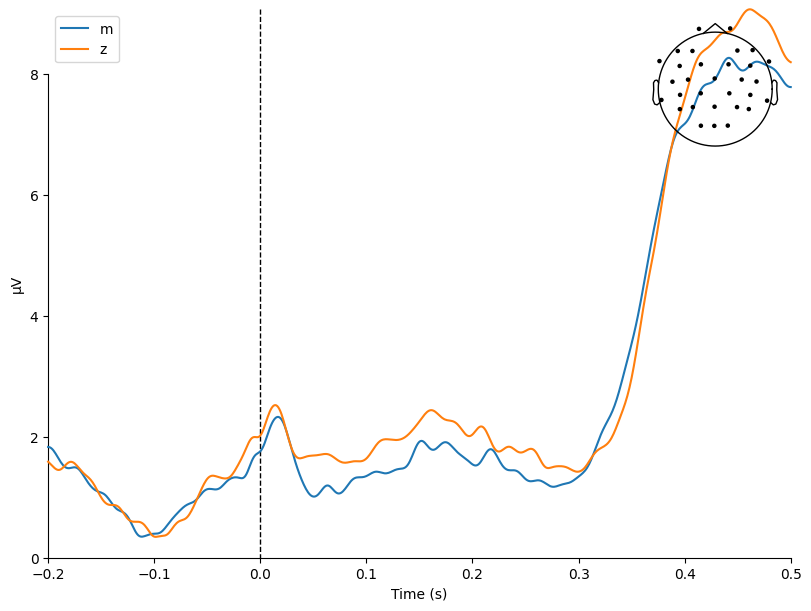

In [10]:
mne.viz.plot_compare_evokeds(dict(m=GA_evo["m"], z=GA_evo["z"]),
                             legend='upper left', show_sensors='upper right');

Lets compare for sensors placed over the right and left motor areas (I have just eyeball'ed not verified by literature)

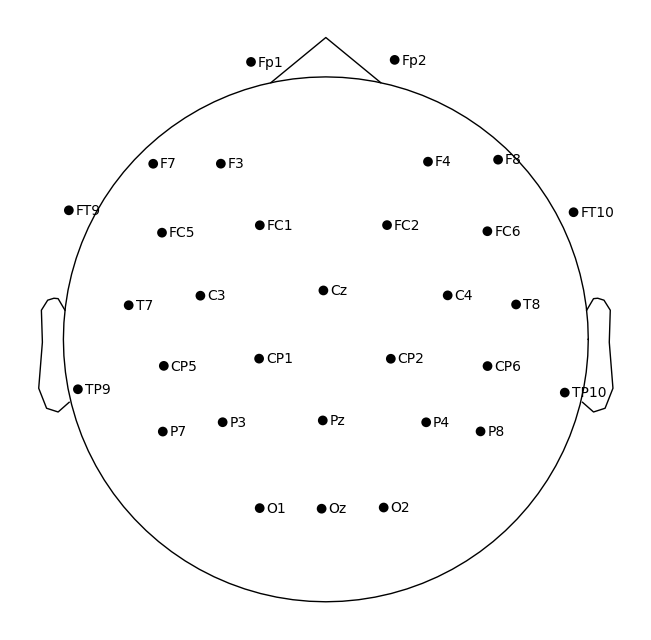

In [12]:
epochs.plot_sensors(show_names=True);

combining channels using "mean"
combining channels using "mean"


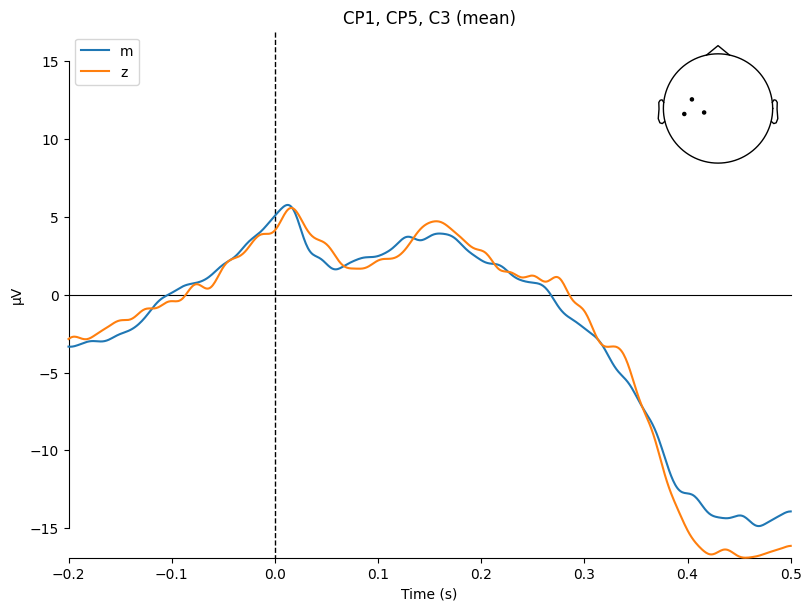

combining channels using "mean"
combining channels using "mean"


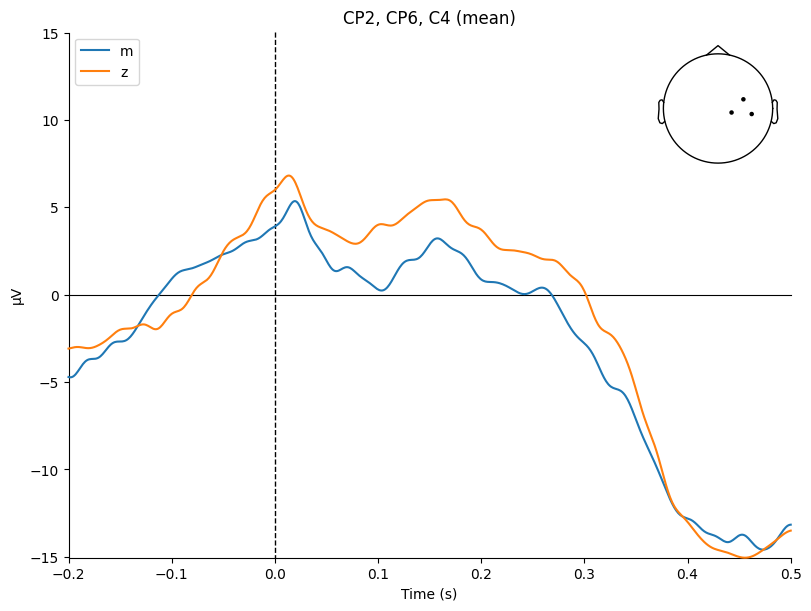

In [13]:
mne.viz.plot_compare_evokeds(
    dict(m=GA_evo["m"], z=GA_evo["z"]),
    legend='upper left', show_sensors='upper right',
    combine = "mean", # plotting mean instead of GFP (global field power)
    picks = ["CP1", "CP5", "C3"] # sensors over left motor cortex
    );

mne.viz.plot_compare_evokeds(
    dict(m=GA_evo["m"], z=GA_evo["z"]),
    legend='upper left', show_sensors='upper right',
    combine = "mean", # plotting mean instead of GFP (global field power)
    picks = ["CP2", "CP6", "C4"] # sensors over right motor cortex
    );

# Now make some beautiful plots of the contrast you are interested in!